## **BBM 444 - Programming Assignment 2: HDR Imaging and Tonemapping**

* You can add as many cells as you want in-between each question, define any function and variable as needed. However, your code needs to be well-commented.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance and by no means are they complete and/or descriptive enough. Accordingly, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so. 
* **Required packages and functions:** numpy, skimage, matplotlib, and cv2 (OpenCV, to read and write HDR files), and you should use the functions provided in the ./ src/cp_assng2.py file of the assignment ZIP archive.
* Working with the provided and captured exposure stacks, you will notice that your algorithms will be using a lot of memory. That's why you should be careful about how many of these images you create in your Python code, as otherwise you run the risk of filling up your memory. Further, you need to make sure you use vectorized code that processes all of its pixels in parallel, as trying to process all 25 million pixels one-by-one with a double for loop will take ages.
* To be able to display HDR images, multiply your image with an appropriate scaling factor of your own (smaller than 1 if the image is very bright, larger than 1 otherwise), apply gamma encoding, and then use the clip and imshow functions as in Programming Assignment 1. You will likely need to experiment with a few different values for the scaling factor you apply, until you find the one that correctly exposes your image. Otherwise, it may appear very bright or very dark.
* There will be a lot of reusing the same functionality, hence implementing the algorithms you are asked with functions (and making appropriate calls when necessary, rather than just code blocks ) is likely to be beneficial.
* You can use the function readHDR in the code we provide to open
and load the .HDR in Python, as otherwise to open HDR images, you'll need a dedicated viewer.
* **This document is also your report. Show your work. Please articulate your arguments well and support them using relevant figures and images.**



### Bora Dere, 2220765021

### 1. HDR Imaging (60 points)

You are provided with both RAW (with .NEF extensions) and rendered (with .JPG extensions) images in the data folder, both of which are to be used to create HDR images.

#### 1.1. Develop RAW images (5 points)

To convert RAW .NEF images into linear 16-bit .TIFF images, use dcraw and specify the camera's profile for white balancing, high-quality interpolation for demosaicing, and sRGB as the output color space. The correct set of flags for this conversion can be found in dcraw's documentation. Report them in the below cell.

##### Command for a single image is:
>dcraw -w -q 3 -4 -T filename.NEF

#### But to run it on all NEF images at once, I used a for loop in PS:
>ls *.NEF | ForEach-Object { dcraw -w -q 3 -4 -T $_.FullName }


#### 1. 2. Weighting Schemes

You are expected to implement 4 different weighting schemes, namely, uniform, tent, Gaussian, and photon. (All hold the assumption that the intensity values z $\in$ [0,1]).

\\begin{eqnarray}
w_{\text{uniform}} & = & \left\{
        \begin{array}{ll}
            1, & \;\, \text{if}\;\, Z_{\text{min}}\leq z \leq Z_{\text{max}}, \\
            0, & \;\, \text{otherwise}
        \end{array},
    \right.\\\nonumber
w_{\text{tent}} & = & \left\{
        \begin{array}{ll}
            \text{min}(z,1-z), & \;\, \text{if}\;\, Z_{\text{min}}\leq z \leq Z_{\text{max}}, \\
            0, & \;\, \text{otherwise}
        \end{array},
    \right. \\\nonumber
w_{\text{Gaussian}} & = & \left\{
        \begin{array}{ll}
            \text{exp}\left(-4\frac{(z-0.5)^2}{0.5^2}\right), & \;\, \text{if}\;\, Z_{\text{min}}\leq z \leq Z_{\text{max}}, \\
            0, & \;\, \text{otherwise}
        \end{array},
    \right. \\\nonumber
w_{\text{photon}} & = & \left\{
        \begin{array}{ll}
            t^k, & \;\, \text{if}\;\, Z_{\text{min}}\leq z \leq Z_{\text{max}}, \\
            0, & \;\, \text{otherwise}
        \end{array},
    \right.
\end{eqnarray} 

Though the recommended values for $Z_{\text{max}}$ and $Z_{\text{min}}$ are 0.05 and 0.95 respectively, you can experiment with different clipping values. 


 

In [191]:
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import cv2

### Constants

In [192]:
K_VALUES = [19, 20, 21, 22, 23, 24, 25, 26, 27]
T_VALUES = [(2**(2*k - 42))/640 for k in K_VALUES]

DATA_PATH = os.path.join(os.getcwd(), 'data', 'Lab Booth')

JPG_SCALE = 255.0
TIFF_SCALE = 65535.0

JPGs = glob.glob(os.path.join(DATA_PATH, '*.jpg'))
JPGs.sort()

TIFFs = glob.glob(os.path.join(DATA_PATH, '*.tiff'))
TIFFs.sort()

### Weight Functions

In [193]:
## Implement (possibly) functions or a class for these weighting schemes
def weight_uniform(z, z_min=0.05, z_max=0.95):
    """Uniform weighting scheme"""
    return np.logical_and(z >= z_min, z <= z_max).astype(float)

def weight_tent(z, z_min=0.05, z_max=0.95):
    """Tent weighting scheme"""
    w = np.minimum(z, 1-z)
    return w * np.logical_and(z >= z_min, z <= z_max).astype(float)

def weight_gaussian(z, z_min=0.05, z_max=0.95):
    """Gaussian weighting scheme"""
    w = np.exp(-4 * ((z - 0.5)**2) / (0.5**2))
    return w * np.logical_and(z >= z_min, z <= z_max).astype(float)

def weight_photon(z, t, k=1, z_min=0.05, z_max=0.95):
    """Photon weighting scheme with parameter k"""
    w = t**k
    return w * np.logical_and(z >= z_min, z <= z_max).astype(float)

#### 1.3. Linearize rendered images (25 points)

Rendered images, being non-linear, need to be linearized before merging into HDR images. For this, we'll use the method by Debevec and Malik [1]. Please refer to the homework text and the paper for any implementation detail.

$I^k_{ij}: $ intensity of pixel (i, j) of the $k^{th}$ image and $I^k_{ij} = f(t^kL_{ij}) $, where $I^k_{ij} \in \{ 0, ..., 255 \}$ and $t^k$ the exposure time of image k. f is the non-linearity introduced by the camera's ISP. That is, calculating its inverse, $f^{-1}$, one can get the linear response.

Instead of $f^{-1}$, recover the function $g =\text{log}(f^{-1})$ that maps the pixel values $I^k_{ij}$ to $g(I^k_{ij})=\text{log}(L_{ij})+\text{log}(t^k)$. **Notice domain of g is discrete** an takes on values in the range $\{ 0, ..., 255 \}$. Hence, the second derivative of g can be approximated via a Laplacian filter.

Assuming static scene upon capturing, $L_{ij}$ is constant across all LDR images. That is, to recover g, the least-squares optimization problem in the hw text needs to be solved. 

*Hint: Solve problem by expressing it in matrix form: $||Av -b ||^2$, where A is a matrix and $\mathbf{v} = [g; \text{log} (L_{ij} )]$ are the unknowns. Use one of NumPy’s solvers to recover the unknowns. (See numpy function numpy.linalg.lstsq)* 

Though, Debevec and Malik [1] recovers a g for each color channel, recovering a single g for all channels suffices for this homework.

Plot the function g you recovered and use it to convert non-linear images into linear.

**Solving the linear equation, unless downsampled, processing the whole image will cause memory error, ie, you will run out of memory. That's why you need to downsample the image I with I[::N, ::N], for some N . We recommend using N = 200. In general it is advisable to use downscaled images during the debugging process of your code to speed up the development process. After ensuring the correctness of the code, the final results can be obtained by running it on the full-resolution image.**


In [194]:
def recover_g(Z, t, w, lambda_, sampling_factor=200, is_photon_weight=False):
    """
    Function to recover the camera response function g
    
    :param Z: LDR images stacked as a 3D array (num_images x height x width x channels)
    :param t: Exposure times for each image
    :param w: Weight function 
    :param lambda\_: Regularization parameter
    :param sampling_factor: Stride for pixel sampling (default: 200)
    :param is_photon_weight: Boolean to indicate if photon weighting is used
    
    :return g: Camera response function for all channels
    """
    n_images, height, width, n_channels = Z.shape
    n = 256 
    
    # sampling
    y_indices = np.arange(0, height, sampling_factor)
    x_indices = np.arange(0, width, sampling_factor)
    Y, X = np.meshgrid(y_indices, x_indices)
    
    y_sampled = Y.flatten()
    x_sampled = X.flatten()
    
    P = len(y_sampled)
    
    pixels = np.zeros((n_images, P, n_channels), dtype=Z.dtype)
    for i in range(n_images):
        pixels[i] = Z[i, y_sampled, x_sampled]
    
    # total number of equations and unknowns
    data_equations = P * n_images * n_channels  # data term 
    smoothness_equations = (n-2)                # regularization term x (one g function)
    constraint_equations = 1                    # fix middle value x (one g function)
    
    total_equations = data_equations + smoothness_equations + constraint_equations
    total_unknowns = n + P * n_channels  
    
    A = np.zeros((total_equations, total_unknowns))
    b = np.zeros(total_equations)
    
    # fill in the data fitting equations
    eq_idx = 0
    for i in range(P):
        for j in range(n_images):
            for c in range(n_channels):
                z = pixels[j, i, c]
                wij = w[z]
                
                A[eq_idx, z] = wij
                A[eq_idx, n + c*P + i] = -wij
                
                # right-hand side
                b[eq_idx] = wij * np.log(t[j])
                
                eq_idx += 1
    
    # smoothness constraints 
    for z in range(1, n-1):
        if is_photon_weight:
            wz = 1.0  # constant weight for regularization with photon weights
        else:
            wz = w[z]  
        
        A[eq_idx, z-1] = lambda_ * wz
        A[eq_idx, z] = -2 * lambda_ * wz
        A[eq_idx, z+1] = lambda_ * wz
        
        # right-hand side is 0
        b[eq_idx] = 0
        
        eq_idx += 1
    
    # fix the curve by setting the middle value to 0
    mid_point = n // 2
    A[eq_idx, mid_point] = 1
    b[eq_idx] = 0
    
    x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    
    g = x[:n]  
    
    return g

In [195]:
## Implement (possibly) a function to conevert non-linear images into linear ones (given the recovered g)
## I = exp(g(I)), where I is the intensity of a pixel
def linearize_images(images, g, is_photon_weight=False):
    """
    Function to apply the response function g to linearize the LDR images
    
    :param images: LDR images 
    :param g: Camera response function(s)
    :param is_photon_weight: Boolean to indicate if photon weighting is used 
    
    :return: linearized: Linearized images
    """
    n_images, height, width, n_channels = images.shape
    linearized = np.zeros_like(images, dtype=float)

    if is_photon_weight:
        for i in range(n_images):
            g_ = g[i]

            for c in range(n_channels):
                linearized[i, :, :, c] = np.exp(g_[images[i, :, :, c]])
    
    else:
        for i in range(n_images):
            for c in range(n_channels):
                linearized[i, :, :, c] = np.exp(g[images[i, :, :, c]])
    
    return linearized

In [196]:
# loading images
images = []
for jpg_path in JPGs:
    img = cv2.imread(jpg_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

Z = np.array(images)

tiff_images = []
for tiff_path in TIFFs:
    img = cv2.imread(tiff_path, cv2.IMREAD_UNCHANGED)  # IMREAD_UNCHANGED to preserve bit depth
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tiff_images.append(img)

Z_tiff = np.array(tiff_images)

In [197]:
w_uniform = np.zeros(256)
w_tent = np.zeros(256)
w_gaussian = np.zeros(256)
w_photon_table = [] # 19, 20, 21, 22, 23, 24, 25, 26, 27

for z in range(256):
    z_norm = z / JPG_SCALE  # normalize to [0, 1]
    w_uniform[z] = weight_uniform(z_norm)
    w_tent[z] = weight_tent(z_norm)
    w_gaussian[z] = weight_gaussian(z_norm)

for exposure_time in T_VALUES:
    w_photon_current = np.zeros(256)
    for z in range(256):
        z_norm = z / JPG_SCALE
        w_photon_current[z] = weight_photon(z_norm, exposure_time)
    w_photon_table.append(w_photon_current)

### Experimenting with Different Lambda Values

In [198]:
t = np.array(T_VALUES)
lambda_values = [50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000]
y = np.arange(0, 256)

In [199]:
g_uniform_functions = []
g_tent_functions = []
g_gaussian_functions = []
g_photon_functions = []

In [200]:
for lambda_ in lambda_values:
    g_uniform = recover_g(Z, t, w_uniform, lambda_)
    g_tent = recover_g(Z, t, w_tent, lambda_)
    g_gaussian = recover_g(Z, t, w_gaussian, lambda_)
    
    g_uniform_functions.append(g_uniform)
    g_tent_functions.append(g_tent)
    g_gaussian_functions.append(g_gaussian)

for i, w_photon in enumerate(w_photon_table): 
    exposure_time_results = []
    
    # different lambda values for each exposure time
    for lambda_ in lambda_values:
        g_photon = recover_g(Z, t, w_photon, lambda_, is_photon_weight=True) 
        exposure_time_results.append(g_photon)
    
    g_photon_functions.append(exposure_time_results)

### Uniform Weighting Function

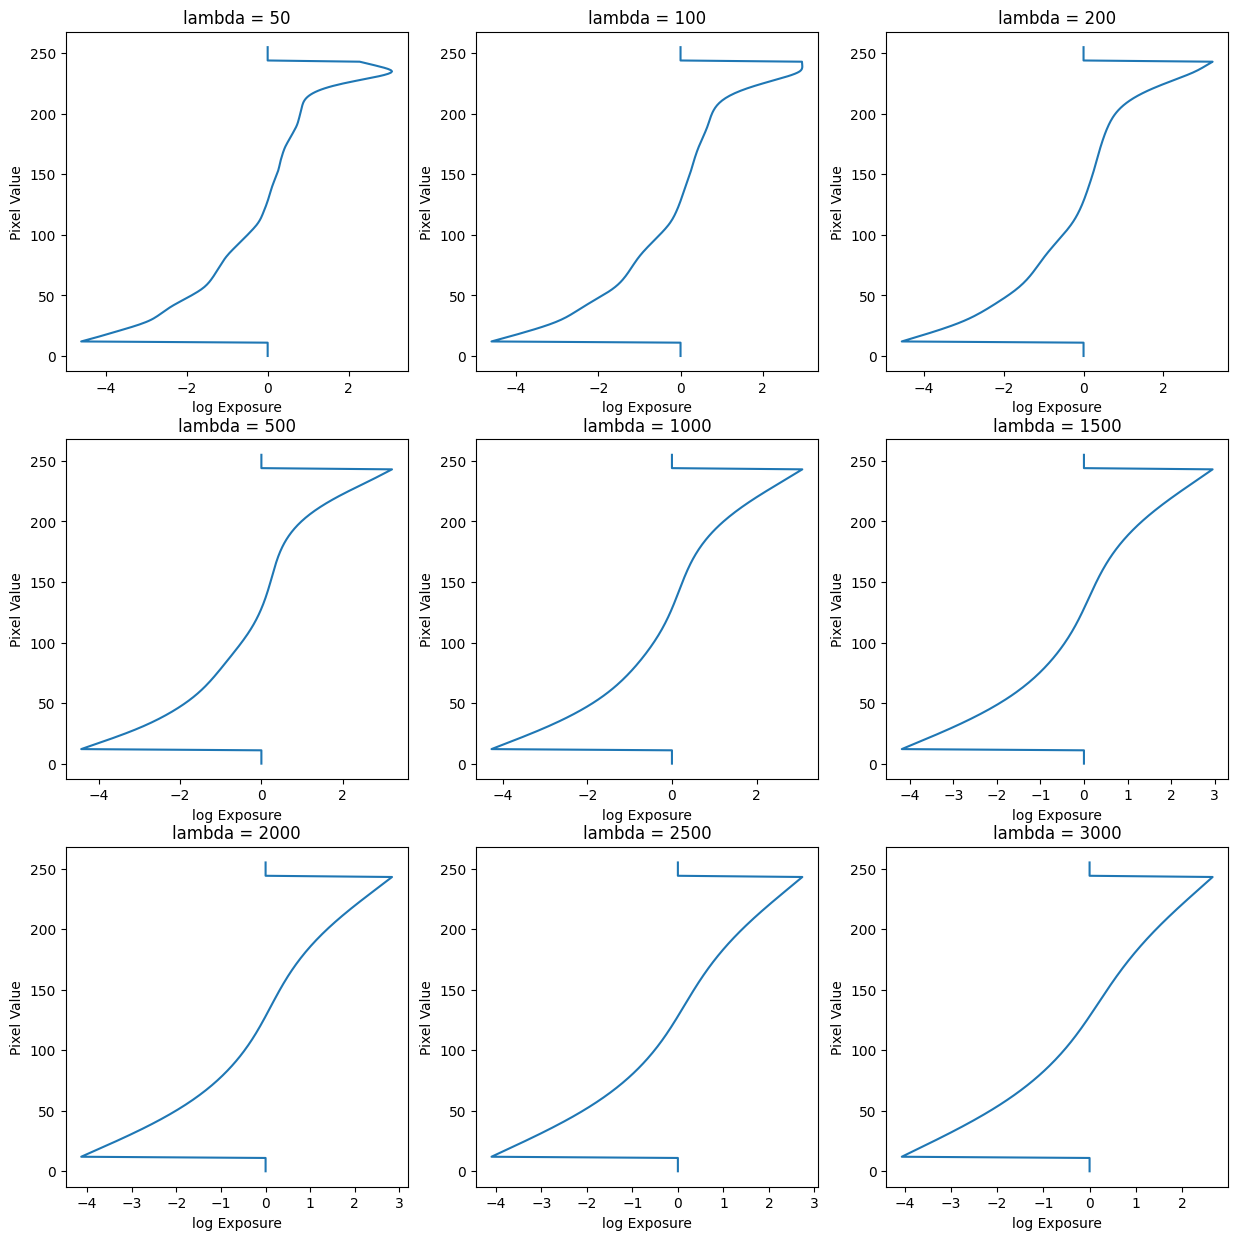

In [201]:
plt.figure(figsize=(15, 15))

for i, g in enumerate(g_uniform_functions):
    plt.subplot(3, 3, i+1)
    plt.plot(g, y)
    plt.title(f'lambda = {lambda_values[i]}')
    plt.xlabel('log Exposure')
    plt.ylabel('Pixel Value')

plt.show()

Two spikes at the two ends of the function are absolutely fine. To be fair, at first, I thought I've done a mistake in the code, since these functions do not look anything like the camera response functions that I've examined to be able to decide on which lambda value is the best. But since we are using $Z_{\text{max}}$ and $Z_{\text{min}}$ as 0.05 and 0.95, respectively, functions generate 0 or infinitesimal values for first and last 12 values, since:
* 0.05 × 255 ≈ 12.75 → first 13 values
* 0.95 × 255 ≈ 242.25 → last 13 values

This can be observed from the following output:

In [202]:
print(f'First 12: {g_uniform_functions[-1][:12]}')
print(f'Last 12: {g_uniform_functions[-1][-12:]}')

First 12: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Last 12: [-7.68807240e-12 -7.71649411e-12 -8.20676860e-13  3.47366580e-12
  4.33297842e-12  1.65556457e-12  3.95794508e-13  4.16022772e-12
 -7.84439180e-12  1.48521195e-11 -8.63842331e-12 -1.91899829e-11]


Among them, lambda=1500 looks the best. From now on, I will be choosing g functions for all weighting functions.

In [203]:
g_uniform = g_uniform_functions[5] # lambda = 1500

### Tent Weighting Function

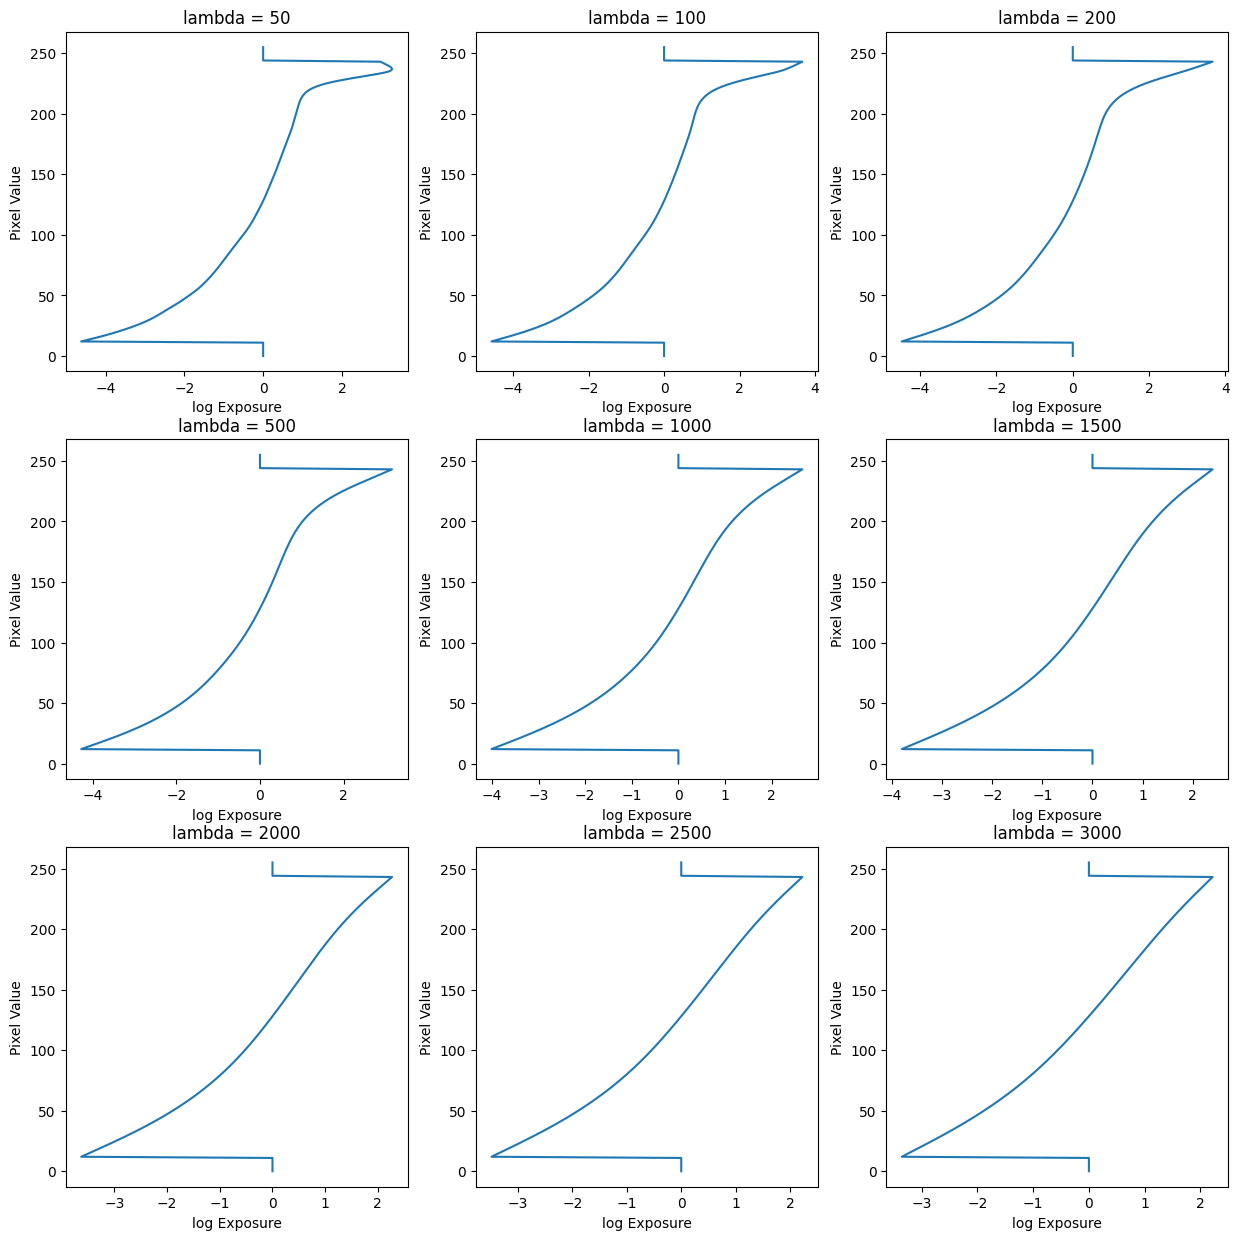

In [204]:
plt.figure(figsize=(15, 15))

for i, g in enumerate(g_tent_functions):
    plt.subplot(3, 3, i+1)
    plt.plot(g, y)
    plt.title(f'lambda = {lambda_values[i]}')
    plt.xlabel('log Exposure')
    plt.ylabel('Pixel Value')

plt.show()

In [205]:
g_tent = g_tent_functions[4] # lambda = 1000

### Gaussian Weighting Function

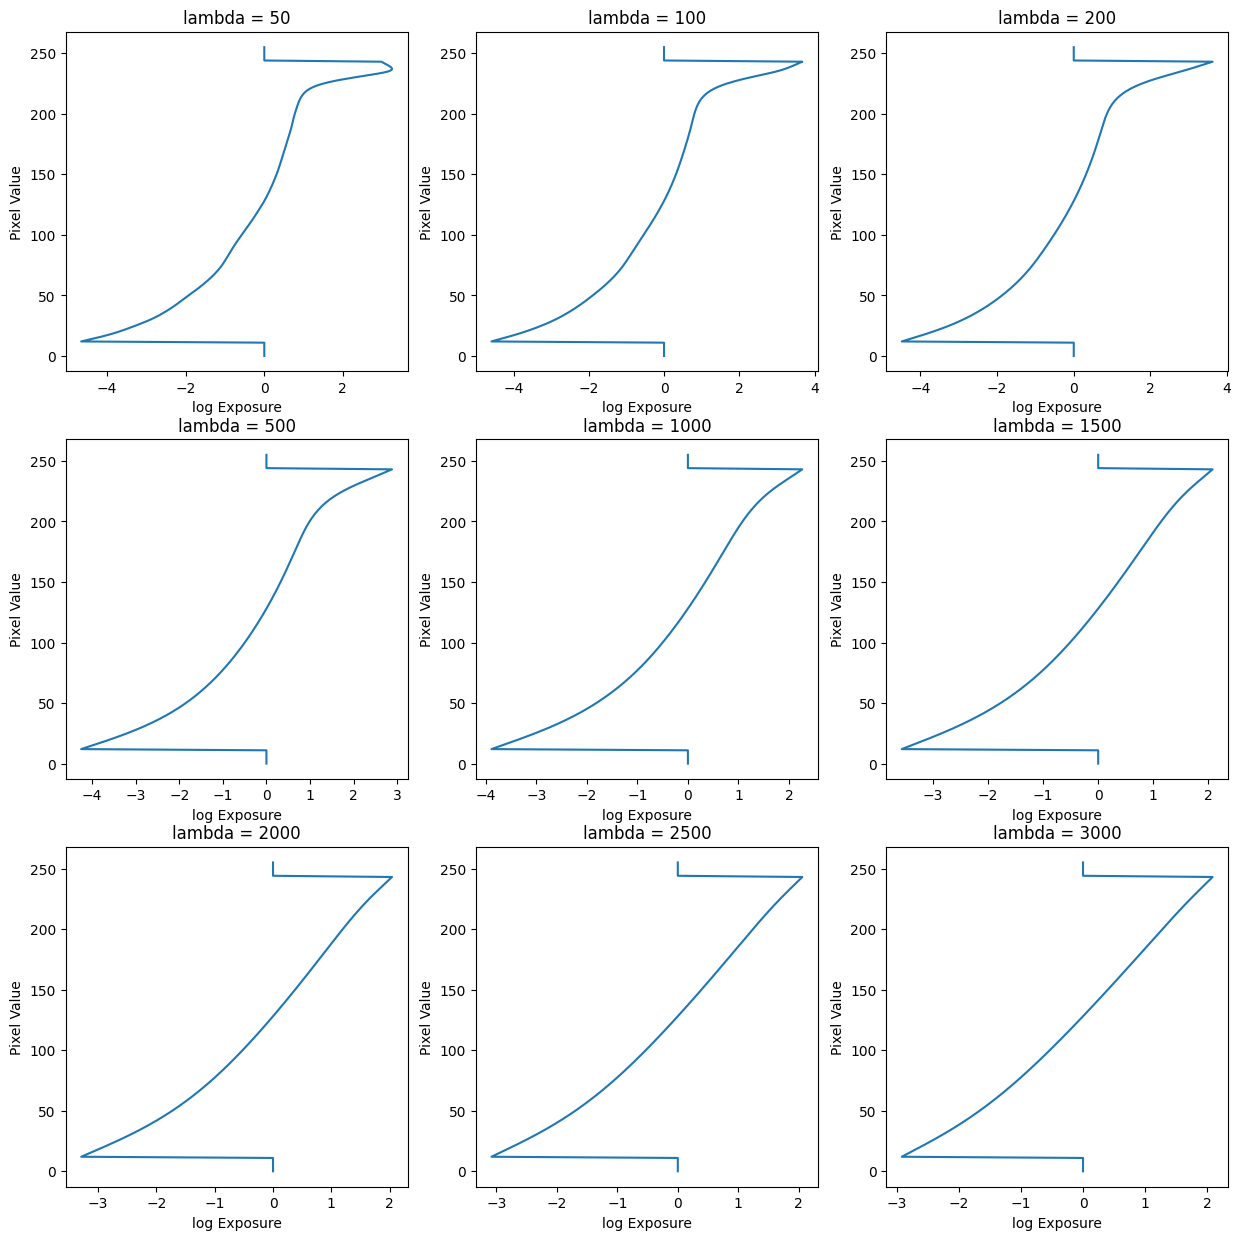

In [206]:
plt.figure(figsize=(15, 15))

for i, g in enumerate(g_gaussian_functions):
    plt.subplot(3, 3, i+1)
    plt.plot(g, y)
    plt.title(f'lambda = {lambda_values[i]}')
    plt.xlabel('log Exposure')
    plt.ylabel('Pixel Value')

plt.show()

In [207]:
g_gaussian = g_gaussian_functions[4] # lambda = 1000

### Photon Weighting Function

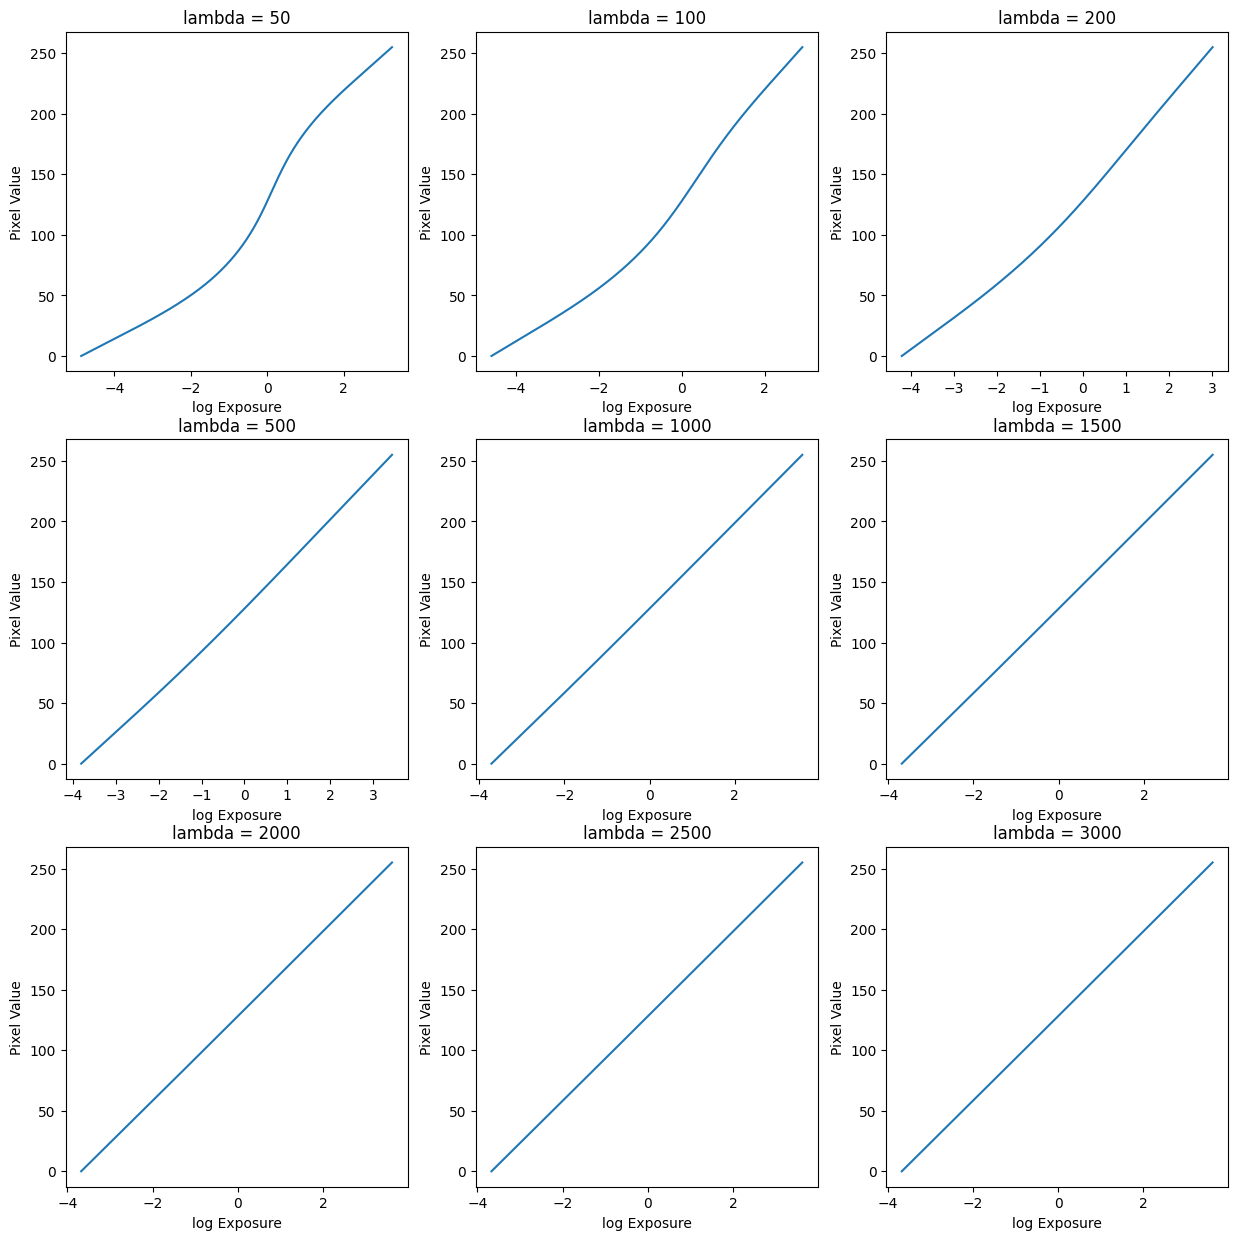

In [208]:
plt.figure(figsize=(15, 15))

for i, g in enumerate(g_photon_functions[4]): # using the middle value
    plt.subplot(3, 3, i+1)
    plt.plot(g, y)
    plt.title(f'lambda = {lambda_values[i]}')
    plt.xlabel('log Exposure')
    plt.ylabel('Pixel Value')

plt.show()

For the photon function, I experimented with different exposure values too. But for the rest of them (especially the ones that are closer to the both ends of the exposure spectrum) the results were unsatisfying. According to my researches, this is because how photon weighting emphasizes different parts of the exposure range:
* Under-exposed images: These mainly capture information in the shadows, so the response looks more linear with less pronounced S-shape.
* Over-exposed images: These capture mainly highlight information, requiring more regularization (higher lambda) to handle potential saturation.
* Middle exposure: This captures the widest usable dynamic range, revealing the true S-shape of the camera response function most clearly.

Examples of response functions for over and under exposed images can be seen below:

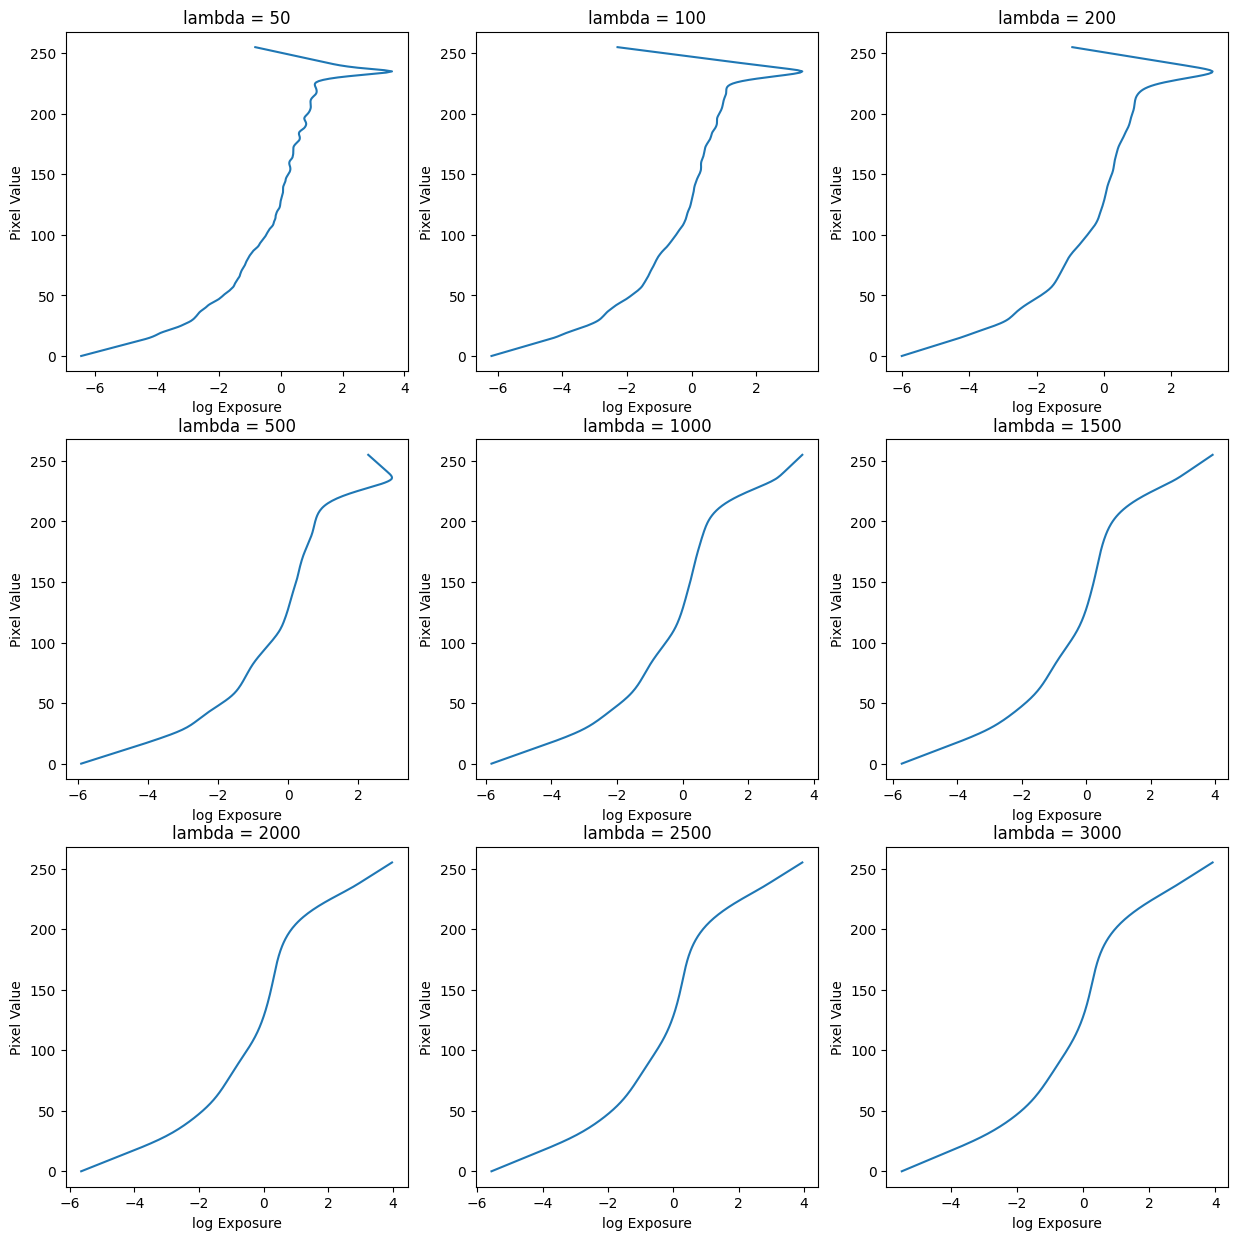

In [209]:
plt.figure(figsize=(15, 15))

for i, g in enumerate(g_photon_functions[-1]): # the last image, over-exposed
    plt.subplot(3, 3, i+1)
    plt.plot(g, y)
    plt.title(f'lambda = {lambda_values[i]}')
    plt.xlabel('log Exposure')
    plt.ylabel('Pixel Value')

plt.show()

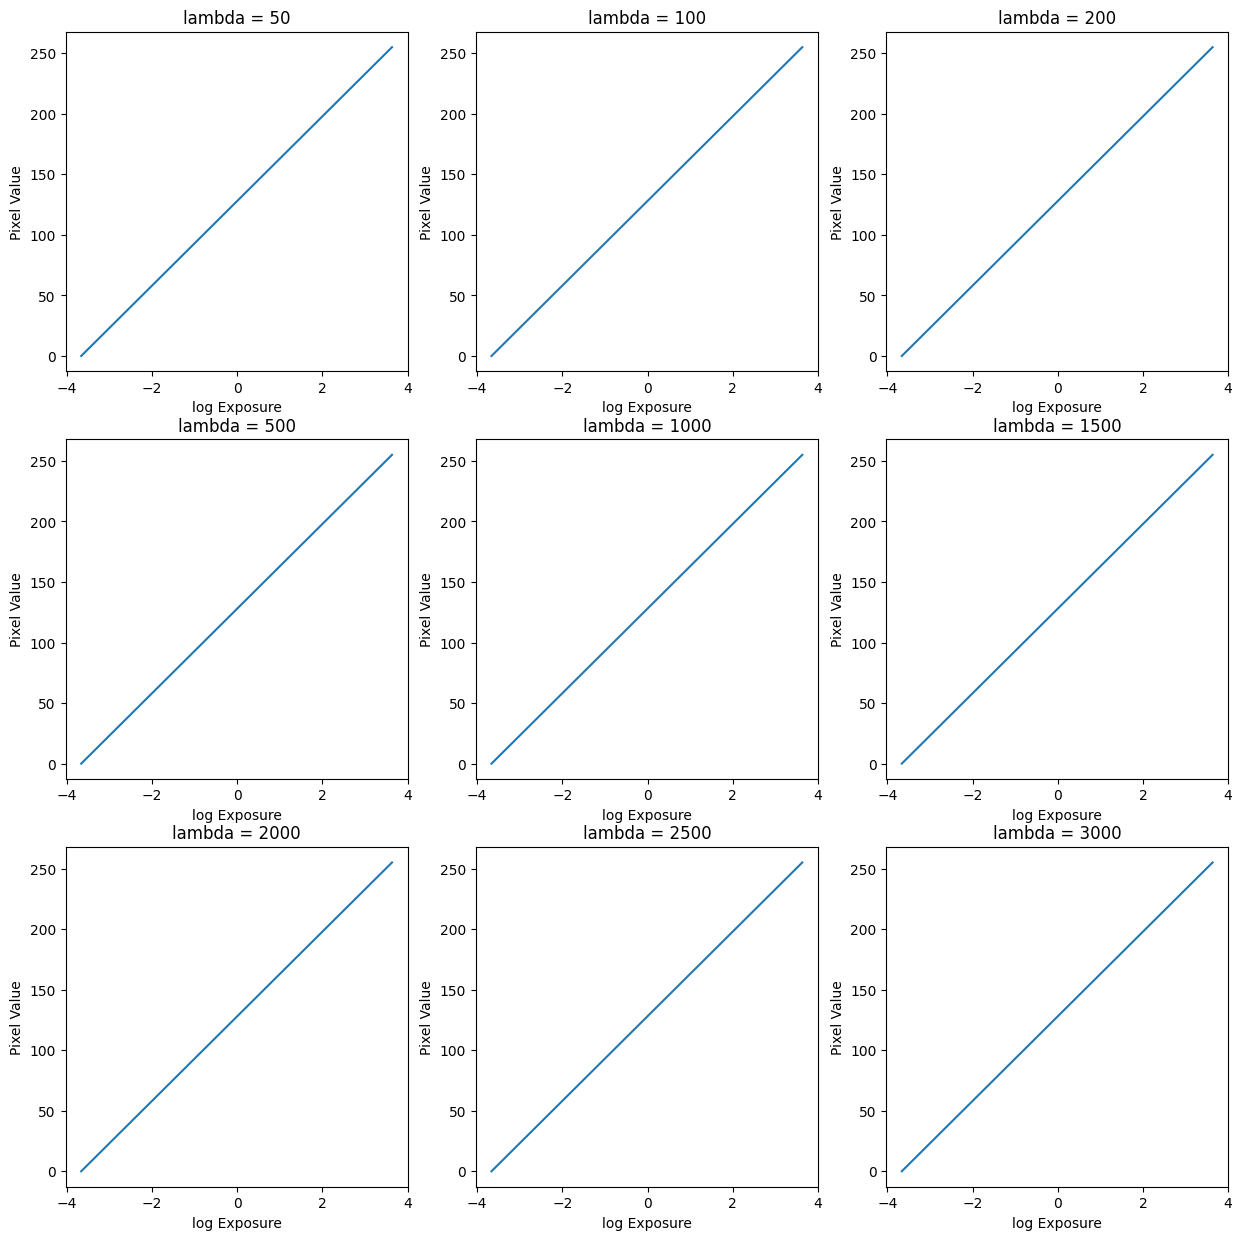

In [210]:
plt.figure(figsize=(15, 15))

for i, g in enumerate(g_photon_functions[0]): # the first image, under-exposed
    plt.subplot(3, 3, i+1)
    plt.plot(g, y)
    plt.title(f'lambda = {lambda_values[i]}')
    plt.xlabel('log Exposure')
    plt.ylabel('Pixel Value')

plt.show()

I will be deciding on the lambda value using the middle value for exposure. That is, I choose 50 as lambda value.

In [211]:
best_lambda = 50
g_photons = []

for i, w_photon in enumerate(w_photon_table):
    g_photon_current = recover_g(Z, t, w_photon, best_lambda, is_photon_weight=True)
    g_photons.append(g_photon_current)

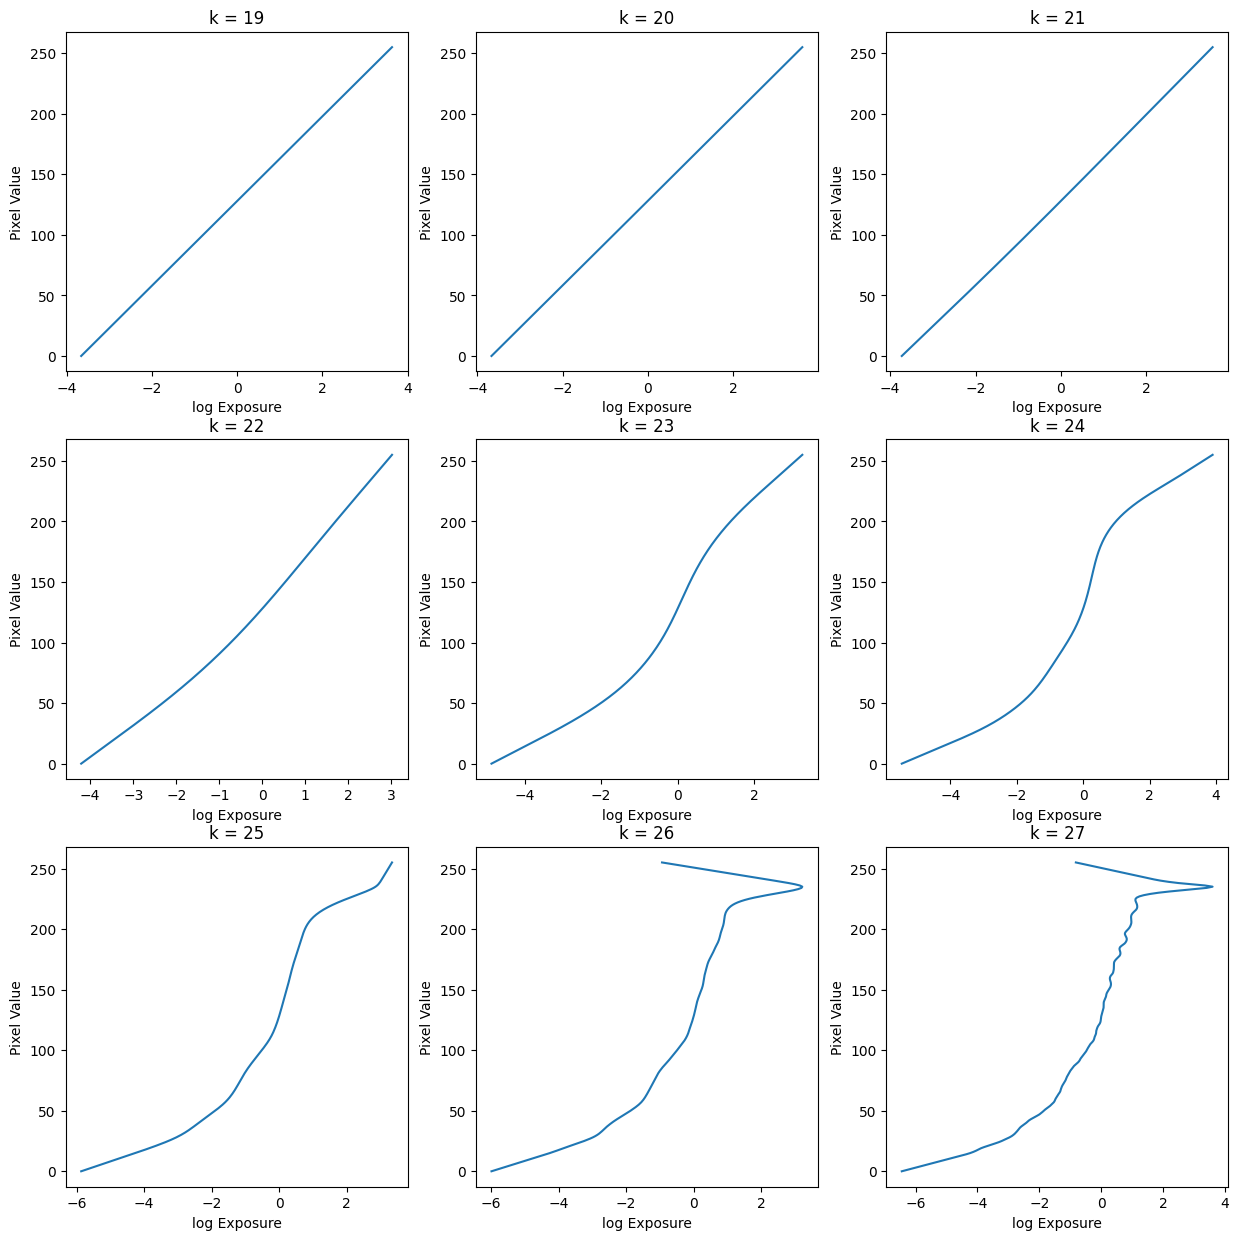

In [212]:
plt.figure(figsize=(15, 15))

for i, g in enumerate(g_photons): 
    plt.subplot(3, 3, i+1)
    plt.plot(g, y)
    plt.title(f'k = {K_VALUES[i]}')
    plt.xlabel('log Exposure')
    plt.ylabel('Pixel Value')

plt.show()

In [213]:
# linearizing images
linearized_uniform = linearize_images(Z, g_uniform, is_photon_weight=False)
linearized_tent = linearize_images(Z, g_tent, is_photon_weight=False)
linearized_gaussian = linearize_images(Z, g_gaussian, is_photon_weight=False)
linearized_photon = linearize_images(Z, g_photons, is_photon_weight=True)

#### 1.4. Merge exposure stack into HDR image (30 points)
Given a set of k LDR linear images corresponding to different exposures $t^k$, we can merge them into an HDR image either in the linear or in the logarithmic domain, where the motivation for the former is physical accuracy, whereas, that for the latter is human visual perception.

Please see the homework text for both algorithms. 

**Merging multiple LDR images, some pixels may not have well-exposed values, which makes the sum of weights in the equations' denominators zero. For over-exposed pixels, assign the maximum valid pixel value, and for under-exposed pixels, assign the minimum valid pixel value.**

In [215]:
## Implement a function for linear merging

In [216]:
## Implement a function for logarithmic merging

#### 1.4. Experiment

You have 2 sets of images (RAW and rendered), 2 merging schemes (linear and logarithmic), and 4 weighting schemes (uniform, tent, Gaussian, and photon-noise optimal), which, in total, makes 16 different HDR images. Additionally, you will need to tune the regularizer hyperparameter $\lambda$.  

Select one out of the sixteen HDR images you created. You can select, for
example, the one that you find the most aesthetically pleasing. Make sure to comment on why you selected the image. Note that, as you have not yet tonemapped your HDR images, if you display them directly they will not look very nice; see “Hints and Information”.

In [217]:
## Experiment. Show your work!

In [218]:
## Plot g

#### *Choose one of the HDR images you have created, commenting on the reason for your choice.*

*Store the resulting HDR images as \texttt{.HDR} files, which is an open source high dynamic range file format. (See the provided function **`writeHDR`**  ./src/cp\_assgn2.py)*

## 2. Color correction and white balancing (20 points)

For this part, you are expected to use the **read_colorchecker_gm()** function provided in **./src/cp_assgn2.py**., which **returns a 4x6 matrix with sRGB linear values of the Greatg-Macbeth color checker.** 



1. For each color checker patch, crop a square that is fully contained within the patch. (See mat-plotlib function matplotlib.pyplot.ginput for interactively recording image coordinates). Make sure to store the coordinates of these cropped squares, so that you can re-use them. Use the resulting 24 crops to compute average RGB coordinates for each of the color checker’s 24 patches
2. Convert these computed RGB coordinates into homogeneous 4 × 1 coordinates, by appending a 1 as their fourth coordinate.
3. Solve a least-squares problem to compute an affine transformation, mapping the measured to the ground-truth  homogeneous coordinates.
4. Apply the computed affine transform to your original RGB HDR image. Note that the
transformed image may have some negative values, which you should clip to 0.
5. Finally, apply an additional white balancing transform (i.e., multiply each channel with a scalar), so that the RGB coordinates of patch 4 are equal to each other. This is analogous to the manual white balancing in Programming Assignment 1, where now we use patch 4 as the white object in the scene.

Store the color corrected and white balanced HDR image in an .HDR file. You should now have two HDR images total: The one from Part 1 that has not been color-corrected, and the one you just created. Compare the color-corrected image with the original, and discuss which one you like the best.


In [219]:
# for each color patch: get 24 crops

In [220]:
# compute average RGB coordinates for each of the color checker’s 24 patches and convert them to 4x1 coords by adding a 1

In [221]:
# compute an affine transformation

In [222]:
# Apply the computed affine transform to your original RGB HDR image

In [223]:
# Apply white balancing

In [224]:
# Store the color corrected HDR image

##### *Compare the color-corrected and the original image here, discussing which one you like better.*

### 3. Photographic tonemapping (20 points)

You need to tonemap the HDR image you like better at the end of the last part for displaying purposes.
You will implement the tonemapping operator proposed by Reinhard et al. [2].
For implementation details, refer to the homework text and the paper.

*You may get better results by using the same scalars for all three channels. You can do this by using pixels from all three channels in the equations.*

$I_{white} = B. max_{i,j}(I_{ij,HDR})$,

$I_{i,j,HDR} = \frac{K}{I_{m,HDR}}$

$I_{m,HDR} = exp(1/N∑_{i,j}log(I_{ij,HDR} + ϵ))$ **Equation (10)**

The parameter K is the key, and determines how bright or dark the resulting tonemapped rendition is. The parameter B is the burn, and can be used to  suppress the contrast of the result. Finally, N is the number of pixels, and ε is a small constant to avoid the singularity of the logarithm function at 0. 

**Even with tonemapping, your images may appear too dark. After tonemapping, you need to apply gamma encoding for images to be displayed correctly.**


### 4. (Bonus)  Create and tonemap your own HDR photos (50 points)

* Apply your implementation on a photograph you have taken. For this, you need to choose a scene with high dynamic range. See the hints section in the homework text for the camera settings.
* Once you select the scene, capture exposure stacks in RAW and JPEG formats. We suggest using exposures that are equally spaced in the logarithmic domain. For example, start with some very low base exposure, and then use exposures that are 2× the base, 4×, 8×, and so on.
* Use the exposure stacks you captured to create two HDR images, one from the RAW and one from the JPEG images. Store these images in .HDR format. You do not need color calibration. 
*Then, process these images using the tonemapping algorithms you implemented in Part 3 (photographic, in RGB or luminance-only). Experiment with different parameters, show a few representative tonemaps, discuss your results, and determine which result you like the most.

In [225]:
## Load your images 

In [226]:
## Create two HDR images (one from RAW and one from JPEG imgs) using the above implemented algorithms

In [227]:
## Tonemap the images with the above-implemented algorithms (in Part 3). Experiment with different parameters. Show some tonemaps

##### *Discuss the above-generated images, commenting on which one you like the best.*

### **REFERENCES**
[1] P. E. Debevec and J. Malik. Recovering high dynamic range radiance maps from photographs.
In Proceedings of the 24th Annual Conference on Computer Graphics and Interactive Techniques,
SIGGRAPH ’97, pages 369–378, New York, NY, USA, 1997. ACM Press/Addison-Wesley Publishing
Co.

[2] E. Reinhard, M. Stark, P. Shirley, and J. Ferwerda. Photographic tone reproduction for digital
images. In Proceedings of the 29th Annual Conference on Computer Graphics and Interactive
Techniques, SIGGRAPH ’02, pages 267–276, New York, NY, USA, 2002. ACM.
